Purpose: To run various downstream analyses on the core stress gene sets, including core genes from set operations, core genes from random forest, and the union of both sets.<br>
Author: Anna Pardo<br>
Date initiated: Aug. 23, 2023

In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statistics
import scipy.stats as stats
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
from venn import venn
from matplotlib.patches import Patch

## Parse random forest core gene list into upregulated & downregulated

In [2]:
# load gene list from random forest
cgrf = pd.read_csv("../../data/core_genes_from_rf.txt",sep="\t",header=None)
cgrf.head()

,0
0,Zm00001eb225440
1,Zm00001eb322670
2,Zm00001eb089800
3,Zm00001eb279710
4,Zm00001eb310450


In [3]:
# load a dictionary of TN-ratios by experiment
## these are the data that were used to generate the set operations core stress gene lists
directory = "../../data/tn_by_experiment_dfs/"
dfdict = {}
for f in os.listdir(directory):
    k = f.strip().split(".")[0]
    dfdict[k] = pd.read_csv(directory+f,sep="\t",header="infer")

In [4]:
dfdict.keys()

dict_keys(['PRJNA172724', 'PRJNA548548', 'Brandon_Webster', 'PRJNA747925', 'PRJNA576545', 'PRJNA339768', 'PRJNA791560', 'PRJNA646054', 'PRJNA545969', 'PRJNA587226', 'PRJNA606824', 'PRJNA379712', 'PRJNA759701', 'PRJNA689935', 'PRJNA520822', 'PRJNA378714', 'PRJNA267717', 'PRJNA647980', 'PRJNA349117', 'PRJNA906711', 'PRJNA687609', 'PRJNA304223', 'PRJNA291919', 'PRJNA436973', 'PRJNA686250', 'PRJNA506720', 'PRJNA244661', 'PRJNA637522', 'PRJNA210356', 'PRJNA611589', 'PRJNA877073', 'PRJNA420600', 'PRJNA414300', 'PRJNA300830', 'PRJNA290180', 'PRJNA556806', 'PRJNA291064', 'PRJNA913846', 'PRJNA794297'])

In [5]:
dfdict["PRJNA290180"].head()

,GeneID,Control,Drought,Salt,Drought_TN,Salt_TN,BioProject
0,Zm00001eb000010,5.416275,4.223263,4.541462,0.814065,0.863657,PRJNA290180
1,Zm00001eb000020,14.511873,5.629578,9.488565,0.427387,0.676164,PRJNA290180
2,Zm00001eb000050,0.015598,0.050461,0.020881,1.034328,1.005201,PRJNA290180
3,Zm00001eb000060,5.382669,4.759840,4.656663,0.902419,0.886254,PRJNA290180
4,Zm00001eb000070,1.532741,1.167229,1.410107,0.855685,0.951581,PRJNA290180


In [6]:
# rename cgrf column
cgrf = cgrf.rename(columns={0:"GeneID"})
cgrf.head()

,GeneID
0,Zm00001eb225440
1,Zm00001eb322670
2,Zm00001eb089800
3,Zm00001eb279710
4,Zm00001eb310450


In [7]:
# for each dataframe in dfdict, add the BioProject to the name of the stressor_TN column
for k in dfdict.keys():
    df = dfdict[k]
    for c in df.columns:
        if c.endswith("_TN"):
            x = c+"_"+k
            df = df.rename(columns={c:x})
    dfdict[k] = df

In [8]:
len(dfdict["PRJNA290180"].index)

39004

In [9]:
# merge the core gene set with each dataframe
coredfs = {}
for k in dfdict.keys():
    df = dfdict[k]
    cdf = cgrf.merge(df)
    coredfs[k] = cdf

In [10]:
len(coredfs["PRJNA290180"].index)

402

In [11]:
# for each dataframe: subset to the up- (TN>2) and downregulated (TN<0.5) genes
upcore = {}
downcore = {}
for k in coredfs.keys():
    df = coredfs[k]
    for c in df.columns:
        if "TN" in c:
            d = df[["GeneID",c]]
            dup = d[d[c]>=2]
            ddn = d[d[c]<=0.5]
            upcore[c] = dup
            downcore[c] = ddn

In [12]:
# for upcore and downcore, pull out all the genes involved as a list, then make that list into a set
## this will give us the upregulated and downregulated core genes from random forest
upcgrf = []
for k in upcore.keys():
    df = upcore[k]
    for g in list(df["GeneID"]):
        upcgrf.append(g)
        
cgrfup = set(upcgrf)

In [13]:
len(cgrfup)

381

In [14]:
dncgrf = []
for k in downcore.keys():
    df = downcore[k]
    for g in list(df["GeneID"]):
        dncgrf.append(g)
        
cgrfdn = set(dncgrf)

In [15]:
len(cgrfdn)

361

In [16]:
len(cgrfup.union(cgrfdn))

398

The above indicates that there exist 4 core stress-important genes from the random forest results which are not "differentially expressed" in any experiment. This could be interesting to follow up on.

In [17]:
# save gene lists
with open("../../data/core_genes_fromRF_upreg.txt","w+") as outfile:
    for i in cgrfup:
        outfile.write(i+"\n")

In [18]:
with open("../../data/core_genes_fromRF_downreg.txt","w+") as outfile:
    for i in cgrfdn:
        outfile.write(i+"\n")

## Transcription factor enrichment tests

In [19]:
# load core stress genes from set operations, and total list of core stress genes (amalgamation of up- and downregulated, and
## non-DE)
upcgso = list(pd.read_csv("../../data/core_upgenes_fromsets.txt",sep="\t",header=None)[0])
dncgso = list(pd.read_csv("../../data/core_downgenes_fromsets.txt",sep="\t",header=None)[0])
cgall = list(pd.read_csv("../../data/union_core_stress_genes.txt",sep="\t",header=None)[0])

In [20]:
allcgso = list(set(upcgso).union(set(dncgso)))

In [21]:
# save allcgso
with open("../../data/core_genes_all_from_setops.txt","w+") as outfile:
    for i in allcgso:
        outfile.write(i+"\n")

In [22]:
allcgrf = list(cgrf["GeneID"])

In [23]:
upcgrf = list(pd.read_csv("../../data/core_genes_fromRF_upreg.txt",sep="\t",header=None)[0])
dncgrf = list(pd.read_csv("../../data/core_genes_fromRF_downreg.txt",sep="\t",header=None)[0])

In [24]:
upcgrf = list(cgrfup)
dncgrf = list(cgrfdn)

In [25]:
# load list of transcription factors
tf = pd.read_csv("../../data/data.csv",sep=",",header="infer")
tf.head()

,number for sorting purposes,protein name,family,gene ID,synonym,clone,all gene IDs,Unnamed: 7
0,1,ZmABI1,ABI3-VP1,Zm00001eb143690,VP1,pUT3351,Zm00001eb143690 Zm00001d042396 GRMZM2G133398,NaN
1,2,ZmABI2,ABI3-VP1,Zm00001eb427970,ABI2,pUT3663,Zm00001d026005 Zm00001eb427970 GRMZM2G018485,NaN
2,3,ZmABI3,ABI3-VP1,Zm00001eb066270,ABI3,pUT3236,Zm00001eb066270 Zm00001d001838 GRMZM2G149940,NaN
3,4,ZmABI4,ABI3-VP1,Zm00001eb051330,ABI4,pUT4675,Zm00001d033313 GRMZM2G098063 Zm00001eb051330,NaN
4,5,ZmABI5,ABI3-VP1,Zm00001eb218990,ABI5,pUT4673,Zm00001d013722 Zm00001eb218990 GRMZM2G320754,NaN


In [26]:
# make a list of TF genes
tfs = []
for i in tf["gene ID"]:
    if type(i)==str:
        if i.startswith("Zm"):
            tfs.append(i.strip())

In [27]:
# load tpm
tpm = pd.read_csv("../../data/rawtpm_bptreat_noPEG.tsv",sep="\t",header="infer")
tpm.head()

,Sample,BioProject,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,SRR11933261,PRJNA637522,Drought,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,...,0.171184,0.000000,0.0,0.0,0.0,0.309501,0.0,0.000000,0.0,0.000000
1,SRR11933272,PRJNA637522,Drought,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,...,0.108052,0.127878,0.0,0.0,0.0,6.703281,0.0,0.000000,0.0,0.000000
2,SRR11933250,PRJNA637522,Drought,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.417565,0.0,0.254123,0.0,1.213349
3,SRR11933029,PRJNA637522,Control,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.370075
4,SRR11933040,PRJNA637522,Drought,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,...,0.178304,0.012158,0.0,0.0,0.0,9.625225,0.0,0.000000,0.0,2.352959


In [28]:
tpm["Treatment"].unique()

array(['Drought', 'Control', 'Heat', 'Cold', 'Salt', 'DroughtRepeat',
       'Low_Nitrogen', 'Flooding'], dtype=object)

In [29]:
# wrangle tpm data
ttpm = tpm.set_index("Sample").drop(["BioProject","Treatment"],axis=1).transpose().reset_index().rename(columns={"index":"GeneID"})
ttpm.head()

Sample,GeneID,SRR11933261,SRR11933272,SRR11933250,SRR11933029,SRR11933040,SRR11932822,SRR11932811,SRR11933230,SRR11932879,...,Ms71D3C,Ki3D1C,CML228D1D,CML333D3D,MO18WD3C,B73D3C,NC358D3C,P39D3D,M162WD3D,M162WD1D
0,Zm00001eb000010,12.553818,16.255838,9.028815,8.201340,10.371251,37.430009,39.925873,30.677016,23.393003,...,1.417104,1.923525,1.427602,9.580153,1.228100,2.966207,1.791556,4.286976,3.435711,3.498243
1,Zm00001eb000020,2.321077,3.110372,2.984479,2.385748,2.799099,27.508819,22.440680,24.648455,7.595576,...,0.000000,1.799671,0.000000,0.000000,1.925157,0.561768,0.176413,0.781353,0.379497,0.463832
2,Zm00001eb000050,0.042520,0.405226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.304751,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Zm00001eb000060,12.932676,7.214039,3.092442,1.726808,1.280629,29.510498,22.148225,22.170584,14.727189,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Zm00001eb000070,5.253755,1.902461,2.586555,1.926412,3.771234,7.005587,7.590336,5.274585,2.177748,...,0.000000,0.451827,0.000000,1.018369,0.000000,0.000000,0.000000,0.000000,1.660372,0.748587


In [30]:
# extract just gene IDs
gid = pd.DataFrame(ttpm["GeneID"])
gid.head()

,GeneID
0,Zm00001eb000010
1,Zm00001eb000020
2,Zm00001eb000050
3,Zm00001eb000060
4,Zm00001eb000070


In [31]:
# set up a column indicating whether the gene ID is a transcription factor or not
# also another column indicating whether the gene ID is a core stress gene or not
# define a function to do this
def data_setup(coregenelist):
    coreornot = []
    tfornot = []
    for g in list(gid["GeneID"]):
        if g in list(tf["gene ID"]):
            tfornot.append("Yes")
        else:
            tfornot.append("No")
        if g in coregenelist:
            coreornot.append("Yes")
        else:
            coreornot.append("No")
    gid["isTF"] = tfornot
    gid["isCore"] = coreornot
    return gid

In [32]:
# define a function to run the whole Fisher's test
def run_fisher(coregenelist):
    df = data_setup(coregenelist)
    # set up the table for Fisher's exact test
    data = pd.crosstab(index=df["isTF"],columns=df["isCore"])
    # run Fisher's exact test
    odds_ratio, p_value = stats.fisher_exact(data)
    print('odd ratio is : ' + str(odds_ratio))
    print('p_value is : ' + str(p_value))
    return (odds_ratio, p_value)

In [33]:
# list of lists of different sets of core genes
ld = {"All":cgall,"All_SetOps":allcgso,"All_RF":allcgrf,"Up_SetOps":upcgso,"Down_SetOps":dncgso,"Up_RF":upcgrf,
      "Down_RF":dncgrf,"Up_All":allcoreup,"Down_All":allcoredn}

NameError: name 'allcoreup' is not defined

In [ ]:
#loop through core gene sets and test for enrichment of TFs vs other genes
p_values = [run_fisher(i)[1] for i in ld.values()]
odds_ratios = [run_fisher(i)[0] for i in ld.values()]
ids = [i for i in ld.keys()]
tf_enrinchment_res = pd.DataFrame({"Set Name": ids,
                                  "Odds Ratio": odds_ratios,
                                  "P-value": p_values})

In [ ]:
 tf_enrinchment_res["P-value"]

In [ ]:
tf_enrinchment_res["P-adj"] = fdrcorrection(tf_enrinchment_res["P-value"])[1]

In [ ]:
tf_enrinchment_res

In [ ]:
run_fisher(cgall)

In [ ]:
run_fisher(allcgso)

In [ ]:
run_fisher(allcgrf)

In [ ]:
run_fisher(upcgso)

In [ ]:
run_fisher(dncgso)

In [ ]:
run_fisher(upcgrf)

In [ ]:
run_fisher(dncgrf)

In [ ]:
allcoreup = list(set(upcgrf).union(set(upcgso)))
allcoredn = list(set(dncgrf).union(set(dncgso)))

In [ ]:
# save allcoreup and allcoredn
with open("../../data/core_genes_all_upreg.txt","w+") as outfile:
    for i in allcoreup:
        outfile.write(i+"\n")

In [ ]:
with open("../../data/core_genes_all_downreg.txt","w+") as outfile:
    for i in allcoredn:
        outfile.write(i+"\n")

In [ ]:
run_fisher(allcoreup)

In [ ]:
run_fisher(allcoredn)

## Make a heatmap of different core sets under different conditions

In [ ]:
ttpm.head()

In [ ]:
# subset genes to only those in the RF-only core stress genes (e.g. without the 45 that overlap)
## set up a list of the 45 that overlap and the unique RF and set ops genes
overlap = list(set(allcgrf).intersection(set(allcgso)))
rfonly = list(set(allcgrf).difference(set(allcgso)))
soonly = list(set(allcgso).difference(set(allcgrf)))

In [ ]:
overlaptpm = ttpm[ttpm["GeneID"].isin(overlap)].set_index("GeneID")
rfonlytpm = ttpm[ttpm["GeneID"].isin(rfonly)].set_index("GeneID")
soonlytpm = ttpm[ttpm["GeneID"].isin(soonly)].set_index("GeneID")

In [ ]:
# log transform the tpm matrices
overlap_log = overlaptpm.apply(lambda x: np.log2(x+1))
rfonly_log = rfonlytpm.apply(lambda x: np.log2(x+1))
soonly_log = soonlytpm.apply(lambda x: np.log2(x+1))

In [ ]:
tpm[["Sample","BioProject","Treatment"]].head()

In [ ]:
# for overlap_log, merge with the metadata to add treatment and BioProject columns back in
## actually just need to merge with the original tpm dataframe
overlap_log_t = overlap_log.transpose().reset_index().merge(tpm[["Sample","BioProject","Treatment"]])
overlap_log_t.head()

In [ ]:
overlap_log_td = overlap_log_t.drop("Sample",axis=1)

In [ ]:
overlap_log = overlap_log.set_index(["Treatment","BioProject"])

In [ ]:
overlap_log_td["Treatment"].mask(overlap_log_td["Treatment"]=="DroughtRepeat","Drought",inplace=True)

In [ ]:
# Create a palette based on unique class labels
palette = sns.color_palette('tab10', n_colors=overlap_log_td['Treatment'].nunique())

In [ ]:
td = {"Flooding":0,"Drought":1,"Control":2,"Salt":3,"Cold":4,"Low_Nitrogen":5,"Heat":6}

In [ ]:
# Map each class label to a color
overlap_log_td.replace({"Treatment":td},inplace=True)
row_colors = overlap_log_td['Treatment'].map(lambda x: palette[int(x)])

In [ ]:
sns.clustermap(
    overlap_log_td.drop(columns=['Treatment',"BioProject"]),
    cmap='viridis',
    yticklabels=False,
    row_cluster=True,
    col_cluster=True,
    figsize=(12, 20),  # Adjust size as needed
    row_colors=row_colors,
    dendrogram_ratio=(.1, .2)
)
plt.savefig("../../figures/core_genes_overlap_RF_setops_heatmap.pdf",bbox_inches="tight")

In [ ]:
# repeat for RF-only genes
rfonly_log_t = rfonly_log.transpose().reset_index().merge(tpm[["Sample","BioProject","Treatment"]])
rfonly_log_td = rfonly_log_t.drop("Sample",axis=1)
rfonly_log_td["Treatment"].mask(rfonly_log_td["Treatment"]=="DroughtRepeat","Drought",inplace=True)

In [ ]:
# Map each class label to a color
rfonly_log_td.replace({"Treatment":td},inplace=True)
row_colors = overlap_log_td['Treatment'].map(lambda x: palette[int(x)])

In [ ]:
sns.clustermap(
    rfonly_log_td.drop(columns=['Treatment',"BioProject"]),
    cmap='viridis',
    yticklabels=False,
    row_cluster=True,
    col_cluster=True,
    figsize=(12, 20),  # Adjust size as needed
    row_colors=row_colors,
    dendrogram_ratio=(.1, .2)
)
plt.savefig("../../figures/core_genes_RF_only_heatmap.pdf",bbox_inches="tight")

In [ ]:
# repeat for set ops-only genes
soonly_log_t = soonly_log.transpose().reset_index().merge(tpm[["Sample","BioProject","Treatment"]])
soonly_log_td = soonly_log_t.drop("Sample",axis=1)
soonly_log_td["Treatment"].mask(soonly_log_td["Treatment"]=="DroughtRepeat","Drought",inplace=True)

In [ ]:
# Map each class label to a color
soonly_log_td.replace({"Treatment":td},inplace=True)
row_colors = soonly_log_td['Treatment'].map(lambda x: palette[int(x)])

In [ ]:
sns.clustermap(
    soonly_log_td.drop(columns=['Treatment',"BioProject"]),
    cmap='viridis',
    yticklabels=False,
    row_cluster=True,
    col_cluster=True,
    figsize=(12, 20),  # Adjust size as needed
    row_colors=row_colors,
    dendrogram_ratio=(.1, .2)
)
plt.savefig("../../figures/core_genes_setops_only_heatmap.pdf",bbox_inches="tight")

In [ ]:
### Code from Bob ###

# Get the top 100 feature names
top_100_features = [feature[0] for feature in sorted_feature_importance[:1000]]
# Extract only the top 100 features, along with 'Experiment_Type' and 'Class'
selected_columns = top_100_features + ['Experiment_Type', 'Class_Label']
sub_df = expr_ML_clean[selected_columns]
sub_df[top_100_features] = np.log2(sub_df[top_100_features] + 1)
# Drop Experiment_Type for plotting, but keep Class_Label for hue
plot_df = sub_df.drop(columns=['Experiment_Type'])
# Create a palette based on unique class labels
palette = sns.color_palette('tab10', n_colors=plot_df['Class_Label'].nunique())
# Map each class label to a color
row_colors = plot_df['Class_Label'].map(lambda x: palette[int(x)])
# Create the clustermap
sns.clustermap(
    plot_df.drop(columns='Class_Label'),
    cmap='viridis',
    yticklabels=False,
    row_cluster=True,
    col_cluster=True,
    figsize=(12, 20),  # Adjust size as needed
    row_colors=row_colors,
    dendrogram_ratio=(.1, .2)
)
# Add title
plt.suptitle('Clustermap of Top 100 Features with Class Labels')plt.savefig("heatmap.pdf")
plt.show()  # If you want to also display the plot

## Match up the genes with their names

In [34]:
# load the metadata
zmmd = pd.read_csv("../../data/Zm00001eb.1.fulldata_formatted.txt",sep="\t",header="infer")
zmmd.head()

,gene_model,assembly_version,annotation_version,transcript_count,canonical_transcript_name,tandem_count,chr,gm_start,gm_end,locus_symbol,locus_name,gene_products,obo_terms,obo_names
0,Zm00001eb000010,Zm-B73-REFERENCE-NAM-5.0,Zm00001eb.1,1,Zm00001eb000010_T001,,chr1,34617,40204,,...,...,"{GO:0006353,GO:0006355,GO:0003690,GO:0006353,G...","{""DNA-templated transcription, termination "",""..."
1,Zm00001eb000020,Zm-B73-REFERENCE-NAM-5.0,Zm00001eb.1,4,Zm00001eb000020_T001,,chr1,41214,46762,pco082477,...,...,"{GO:0016301,GO:0006511,GO:0140014,GO:0005813,G...","{""kinase activity"",""ubiquitin-dependent protei..."
2,Zm00001eb000030,Zm-B73-REFERENCE-NAM-5.0,Zm00001eb.1,,,2,chr1,106148,106620,,...,...,...,NaN
3,Zm00001eb000040,Zm-B73-REFERENCE-NAM-5.0,Zm00001eb.1,,,2,chr1,107080,108196,,...,...,...,NaN
4,Zm00001eb000050,Zm-B73-REFERENCE-NAM-5.0,Zm00001eb.1,1,Zm00001eb000050_T001,,chr1,108554,114382,,...,...,"{GO:0043047,GO:0005662,GO:0007004,GO:0006268,G...","{""single-stranded telomeric DNA binding"",""DNA ..."


In [ ]:
type(zmmd.iloc[0,10].strip())

In [ ]:
zmmd.iloc[0,10].strip()

In [ ]:
# rename columns to strip extra whitespace from names
for c in zmmd.columns:
    zmmd.rename(columns={c:c.strip()},inplace=True)

In [ ]:
# merge with overall core stress gene list
## load overall core stress gene list
allcg = list(pd.read_csv("../../data/union_core_stress_genes.txt",sep="\t",header=None)[0])

In [ ]:
zmmd.iloc[0,0]

In [ ]:
cgmd = zmmd[zmmd["gene_model"].isin(allcg)]
len(cgmd.index)==len(allcg)

In [ ]:
len(cgmd.index)

In [ ]:
len(allcg)

In [ ]:
len(cgmd["gene_model"].unique())

In [ ]:
# drop any duplicated rows
cgmd.drop_duplicates(inplace=True)

In [ ]:
len(cgmd.index)

In [ ]:
# there were no duplicated rows, okay then
# so I know, what gene IDs are duplicated?
v = cgmd["gene_model"].value_counts()

Genes appearing more than once:
- Zm00001eb044840
- Zm00001eb079430
- Zm00001eb212120
- Zm00001eb227310
- Zm00001eb325640
- Zm00001eb433050<br>

These genes appear to each have more than one locus name or locus symbol.

In [ ]:
cgmd.head()

In [ ]:
cgmd.loc[74,"gene_model"]

In [ ]:
# pull out the genes with known names: how many unique genes are there?
geneID = []
locusname = []
for i in cgmd.index:
    ln = cgmd.loc[i,"locus_name"]
    if ln.strip() != "":
        locusname.append(ln.strip())
        geneID.append(cgmd.loc[i,"gene_model"])

In [ ]:
# make a dataframe of all the core genes with locus names
named_cg = pd.DataFrame(list(zip(geneID,locusname)),columns=["GeneID","Name"])
len(named_cg["GeneID"].unique())

In [ ]:
# Actually, I want to put together a dataframe (later output to a tsv) of the core genes, showing their names if they have any,
## what method they were found by, and whether upregulated or downregulated or both (under any stress condition at all)
# Before running this I re-ran some cells above to load in all the various core stress gene lists on my file system
# relevant lists: allcoreup, allcoredn, allcgso, allcgrf

upreg = []
downreg = []
RF = []
setops = []
for g in allcg:
    if g in allcoreup:
        upreg.append("Y")
    else:
        upreg.append("N")
        
    if g in allcoredn:
        downreg.append("Y")
    else:
        downreg.append("N")
        
    if g in allcgso:
        setops.append("Y")
    else:
        setops.append("N")
    
    if g in allcgrf:
        RF.append("Y")
    else:
        RF.append("N")

In [ ]:
# make a starter dataframe
cg_info = pd.DataFrame(list(zip(allcg,upreg,downreg,RF,setops)),columns=["gene_model","Upregulated","Downregulated",
                                                                        "From_RF","From_Set_Ops"])
cg_info.head()

In [ ]:
# merge with a couple columns of the metadata df to get the locus names
cg_info2 = cg_info.merge(zmmd[["gene_model","locus_name"]])
cg_info2.head()

In [ ]:
# remove excess space from the locus names
names = []
for n in list(cg_info2["locus_name"]):
    names.append(n.strip())
cg_info2["Name"] = names
cg_info2.head()

In [ ]:
cg_info_final = cg_info2[["gene_model","Name","Upregulated","Downregulated","From_RF","From_Set_Ops"]].rename(
    columns={"gene_model":"GeneID"})
cg_info_final.head()

In [ ]:
# save as a tsv file
cg_info_final.to_csv("../../data/CoreGenes_Final_Info.tsv",sep="\t",header=True,index=False)

## Enrichments of individual TF families

In [35]:
# load the core genes
cg = pd.read_csv("../../data/CoreGenes_Final_Info.tsv",sep="\t",header="infer")
cg.head()

,GeneID,Name,Upregulated,Downregulated,From_RF,From_Set_Ops
0,Zm00001eb418060,glutathione S-transferase2,Y,N,N,Y
1,Zm00001eb225440,NaN,Y,Y,Y,N
2,Zm00001eb197060,NaN,Y,N,N,Y
3,Zm00001eb322670,NaN,Y,Y,Y,N
4,Zm00001eb089800,aconitase8,Y,Y,Y,N


In [36]:
# also, recall the dictionary I made before
ld

NameError: name 'ld' is not defined

In [37]:
tf.head()

,number for sorting purposes,protein name,family,gene ID,synonym,clone,all gene IDs,Unnamed: 7
0,1,ZmABI1,ABI3-VP1,Zm00001eb143690,VP1,pUT3351,Zm00001eb143690 Zm00001d042396 GRMZM2G133398,NaN
1,2,ZmABI2,ABI3-VP1,Zm00001eb427970,ABI2,pUT3663,Zm00001d026005 Zm00001eb427970 GRMZM2G018485,NaN
2,3,ZmABI3,ABI3-VP1,Zm00001eb066270,ABI3,pUT3236,Zm00001eb066270 Zm00001d001838 GRMZM2G149940,NaN
3,4,ZmABI4,ABI3-VP1,Zm00001eb051330,ABI4,pUT4675,Zm00001d033313 GRMZM2G098063 Zm00001eb051330,NaN
4,5,ZmABI5,ABI3-VP1,Zm00001eb218990,ABI5,pUT4673,Zm00001d013722 Zm00001eb218990 GRMZM2G320754,NaN


In [ ]:
# make a new function for setting up data for Fisher's exact test on a given TF family
def tf_family_data_setup(coregenelist,family):
    # subset the tf data to just the family
    fam = tf[tf["family"]==family]
    
    gid = pd.DataFrame(ttpm["GeneID"])
    coreornot = []
    famornot = []
    for g in list(gid["GeneID"]):
        if g in list(fam["gene ID"]):
            famornot.append("Yes")
        else:
            famornot.append("No")
        if g in coregenelist:
            coreornot.append("Yes")
        else:
            coreornot.append("No")
    gid["inFamily"] = famornot
    gid["isCore"] = coreornot
    return gid

In [ ]:
def tf_family_fisher(coregenelist,family):
    df = tf_family_data_setup(coregenelist,family)
    if len(df["inFamily"].unique())==2:
        data = pd.crosstab(index=df["inFamily"],columns=df["isCore"])
        odds_ratio,p_value = stats.fisher_exact(data)
        return (odds_ratio,p_value)
    else:
        return ("NA","NA")

In [ ]:
# make a list of all TF families
type(list(tf["family"].unique()))

In [ ]:
ld.keys()

In [ ]:
# for upregulated core genes from all methods: loop through TF families and test for enrichment of each one, then apply FDR
## correction
ids = [i for i in list(tf["family"].unique())]
pvals = [tf_family_fisher(ld["Up_All"],i)[1] for i in list(tf["family"].unique())]
odds = [tf_family_fisher(ld["Up_All"],i)[0] for i in list(tf["family"].unique())]

In [ ]:
# make results dataframe
upres = pd.DataFrame(list(zip(ids,pvals,odds)),columns=["TF_Family","p_value","odds_ratio"])

In [ ]:
upres.head()

In [ ]:
# drop NA rows
upres = upres[upres["p_value"]!="NA"]

In [ ]:
# run FDR on p-values
upres["p-adj"] = fdrcorrection(upres["p_value"])[1]
upres.head()

In [ ]:
# what families are significant?
upres[upres["p-adj"]<0.1]

In [ ]:
# repeat for downregulated core genes
ids = [i for i in list(tf["family"].unique())]
pvals = [tf_family_fisher(ld["Down_All"],i)[1] for i in list(tf["family"].unique())]
odds = [tf_family_fisher(ld["Down_All"],i)[0] for i in list(tf["family"].unique())]

In [ ]:
dnres = pd.DataFrame(list(zip(ids,pvals,odds)),columns=["TF_Family","p_value","odds_ratio"])

In [ ]:
dnres = dnres[dnres["p_value"]!="NA"]
dnres["p-adj"] = fdrcorrection(dnres["p_value"])[1]

In [ ]:
dnres[dnres["p-adj"]<0.1]

In [ ]:
# pull out a list of the HSF genes that are present in the upregulated core set
## also the NACs, AP2/ERF-AP2s, AP2/ERF-ERFs, and bZIPs
## and the AP2/ERF-AP2s in the downregulated genes
## save as a file for tomorrow or whenever
cgt = cg.rename(columns={"GeneID":"gene ID"}).merge(tf[["gene ID","family","protein name"]])
len(cgt.index)

In [ ]:
cgt.head()

In [ ]:
families = ["HSF","AP2/ERF-AP2","AP2/ERF-ERF","bZIP","NAC"]
famofint = cgt[cgt["family"].isin(families)]
famofint["family"].unique()

In [ ]:
famofint.to_csv("../../data/core_genes_TF_fam_of_interest.tsv",sep="\t",header=True,index=False)

## Are modules containing upregulated TFs of interest enriched in core genes?

In [38]:
# load core gene TFs of interest
cgtf = pd.read_csv("../../data/core_genes_TF_fam_of_interest.tsv",sep="\t",header="infer")
cgtf.head()

,gene ID,Name,Upregulated,Downregulated,From_RF,From_Set_Ops,family,protein name
0,Zm00001eb042240,DRE-binding protein 1,Y,N,Y,N,AP2/ERF-ERF,ZmEREB204
1,Zm00001eb249290,AP2-EREBP-transcription factor 195,N,Y,N,Y,AP2/ERF-AP2,ZmEREB195
2,Zm00001eb318890,AP2-EREBP-transcription factor 36,Y,Y,Y,N,AP2/ERF-AP2,ZmEREB36
3,Zm00001eb296430,AP2-EREBP-transcription factor 34,Y,Y,Y,N,AP2/ERF-AP2,ZmEREB34
4,Zm00001eb146690,bZIP-transcription factor 95,Y,N,Y,N,bZIP,ZmbZIP95


In [ ]:
# load coexpression module data
directory = "../../data/WGCNA_output/outputs_from_hpcc/"
modgenes = {}
for filename in os.listdir(directory):
    if filename.endswith("_genes.csv"):
        modname = filename.split("_")[0]
        df = pd.read_csv(directory+filename,sep="\t",header="infer")
        #print(df.head())
        genelist = list(df["x"])
        modgenes[modname] = genelist

In [ ]:
# for each gene in cgtf, find what module(s) it is in and append as a column
mods = []
for g in list(cgtf["gene ID"]):
    for m in modgenes.keys():
        l = modgenes[m]
        if g in l:
            mods.append(m)

In [ ]:
cgtf["Module"] = mods
cgtf.head()

In [ ]:
# for each module listed in this new column, test if it is enriched in core genes
## to do this I need to load all the core genes, and in fact all the genes
# load tpm
tpm = pd.read_csv("../../data/rawtpm_bptreat_noPEG.tsv",sep="\t",header="infer")

In [ ]:
# load the core genes
cg = pd.read_csv("../../data/CoreGenes_Final_Info.tsv",sep="\t",header="infer")

In [ ]:
# subset to genes that are not in the set of TFs of interest
nontf = cg[~cg["GeneID"].isin(list(cgtf["gene ID"]))]

In [ ]:
# Fisher table will be set up as isCore, inModule
def mod_data_setup(coregeneset,modulegenes):
    coreornot = []
    modornot = []
    for g in list(ttpm["GeneID"].unique()):
        if g in modulegenes:
            modornot.append("Yes")
        else:
            modornot.append("No")
        if g in coregeneset:
            coreornot.append("Yes")
        else:
            coreornot.append("No")
    df = pd.DataFrame(list(zip(list(ttpm["GeneID"].unique()),coreornot,modornot)),columns=["GeneID","isCore","inModule"])
    return df

In [ ]:
def mod_fisher(coregeneset,module):
    # get list of genes in module
    mg = modgenes[module]
    df = mod_data_setup(coregeneset,mg)
    data = pd.crosstab(index=df["inModule"],columns=df["isCore"])
    odds_ratio, p_value = stats.fisher_exact(data)
    return (odds_ratio,p_value)

In [ ]:
# wrangle tpm data
ttpm = tpm.set_index("Sample").drop(["BioProject","Treatment"],axis=1).transpose().reset_index().rename(columns={"index":"GeneID"})
ttpm.head()

In [ ]:
# for all core genes
pvals = [mod_fisher(list(cg["GeneID"].unique()),i)[1] for i in modgenes.keys()]
odds = [mod_fisher(list(cg["GeneID"].unique()),i)[0] for i in modgenes.keys()]
ids = [i for i in modgenes.keys()]
modres = pd.DataFrame(list(zip(ids,pvals,odds)),columns=["Module","P-value","Odds Ratio"])

In [ ]:
# for non-TF-families-of-interest core genes
pvals = [mod_fisher(list(nontf["GeneID"].unique()),i)[1] for i in modgenes.keys()]
odds = [mod_fisher(list(nontf["GeneID"].unique()),i)[0] for i in modgenes.keys()]
ids = [i for i in modgenes.keys()]
ntmodres = pd.DataFrame(list(zip(ids,pvals,odds)),columns=["Module","P-value","Odds Ratio"])

In [ ]:
modres["P-adj"] = fdrcorrection(modres["P-value"])[1]
modres.head()

In [ ]:
ntmodres["P-adj"] = fdrcorrection(ntmodres["P-value"])[1]
ntmodres.head()

In [ ]:
# subset to the modules containing the genes of interest
intmods = list(cgtf["Module"].unique())
intmodenrich = modres[modres["Module"].isin(intmods)]
intmodenrich

In [ ]:
intmods = list(cgtf["Module"].unique())
intmodenrich = ntmodres[ntmodres["Module"].isin(intmods)]
intmodenrich

In [ ]:
modres[modres["P-adj"]<0.05]

In [ ]:
ntmodres[ntmodres["P-adj"]<0.05]

## Look through named non-TF core genes

In [39]:
# load gene information
cginfo = pd.read_csv("../../data/CoreGenes_Final_Info.tsv",sep="\t",header="infer")
cginfo.head()

,GeneID,Name,Upregulated,Downregulated,From_RF,From_Set_Ops
0,Zm00001eb418060,glutathione S-transferase2,Y,N,N,Y
1,Zm00001eb225440,NaN,Y,Y,Y,N
2,Zm00001eb197060,NaN,Y,N,N,Y
3,Zm00001eb322670,NaN,Y,Y,Y,N
4,Zm00001eb089800,aconitase8,Y,Y,Y,N


In [ ]:
# drop genes with no names
named = cginfo.dropna(axis=0)
len(named["GeneID"].unique())

In [ ]:
# load list of transcription factors
tf = pd.read_csv("../../data/data.csv",sep=",",header="infer")
tf.head()

In [ ]:
# subset to non-TF genes
nontf = named[~named["GeneID"].isin(list(tf["gene ID"].unique()))]
len(nontf["GeneID"].unique())

In [ ]:
nontf.head()

In [ ]:
# sort nontf alphabetically by name - this should make it easier to look through manually
nontf = nontf.sort_values(by=["Name"])

In [ ]:
# save nontf so I can look through it
nontf.to_csv("../../data/named_coregenes_non_TFs.tsv",sep="\t",header=True,index=False)

## Test for independence/non-independence of the two methods' core sets

In [ ]:
# load tpm
tpm = pd.read_csv("../../data/rawtpm_bptreat_noPEG.tsv",sep="\t",header="infer")
# wrangle tpm data
ttpm = tpm.set_index("Sample").drop(["BioProject","Treatment"],axis=1).transpose().reset_index().rename(columns={"index":"GeneID"})

In [ ]:
# load gene information
cginfo = pd.read_csv("../../data/CoreGenes_Final_Info.tsv",sep="\t",header="infer")
cginfo.head()

In [ ]:
cginfo[cginfo["GeneID"]=="Zm00001eb418060"].iloc[0,5]

In [ ]:
rfornot = []
soornot = []
gid = pd.DataFrame(ttpm["GeneID"])
for g in list(gid["GeneID"]):
    if g in list(cginfo["GeneID"]):
        df = cginfo[cginfo["GeneID"]==g]
        if df.iloc[0,4]=="Y":
            rfornot.append("Yes")
        else:
            rfornot.append("No")
        if df.iloc[0,5]=="Y":
            soornot.append("Yes")
        else:
            soornot.append("No")
    else:
        rfornot.append("No")
        soornot.append("No")
gid["fromRF"] = rfornot
gid["fromSetOps"] = soornot

In [ ]:
data = pd.crosstab(index=gid["fromRF"],columns=gid["fromSetOps"])
data

In [ ]:
odds_ratio,p_value = stats.fisher_exact(data)
print("odds ratio is:"+str(odds_ratio))
print("p value is:"+str(p_value))

## Make basic Venn diagrams of core gene sets from different methods

In [2]:
# load gene information
cginfo = pd.read_csv("../../data/CoreGenes_Final_Info.tsv",sep="\t",header="infer")
cginfo.head()

,GeneID,Name,Upregulated,Downregulated,From_RF,From_Set_Ops
0,Zm00001eb418060,glutathione S-transferase2,Y,N,N,Y
1,Zm00001eb225440,NaN,Y,Y,Y,N
2,Zm00001eb197060,NaN,Y,N,N,Y
3,Zm00001eb322670,NaN,Y,Y,Y,N
4,Zm00001eb089800,aconitase8,Y,Y,Y,N


In [3]:
# need to make a dictionary of sets of gene IDs - 2 sets: from RF & from set ops
fromrf = cginfo[cginfo["From_RF"]=="Y"]
fromso = cginfo[cginfo["From_Set_Ops"]=="Y"]

In [8]:
# load "core gene" list from single stressor RFs
cgssrf = pd.read_csv("../../data/coregenes_single_stress_RF.txt",sep="\t",header=None)
cgssrf.head()

,0
0,Zm00001eb125810
1,Zm00001eb001160
2,Zm00001eb117740
3,Zm00001eb013920
4,Zm00001eb429410


In [9]:
forvenn = {"From Random Forest":set(list(fromrf["GeneID"])),"From Set Operations":set(list(fromso["GeneID"])),
           "From Single-Stressor RF":set(list(cgssrf[0]))}

Text(0.5, 1.0, 'Core Genes from Different Methods')

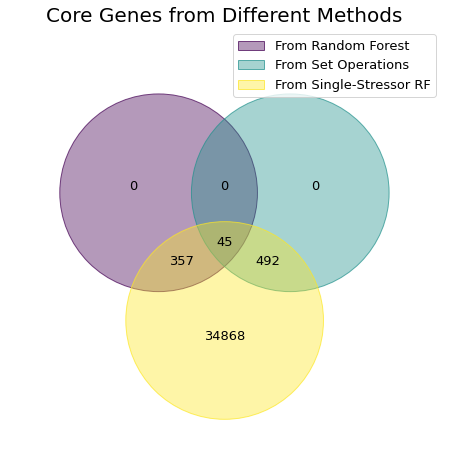

In [10]:
venn(forvenn)
plt.title("Core Genes from Different Methods",fontsize=20)
#plt.savefig("../../figures/core_genes_from_methods_venn.svg")

In [ ]:
# repeat for upregulated genes and downregulated genes
upcg = cginfo[cginfo["Upregulated"]=="Y"]
dncg = cginfo[cginfo["Downregulated"]=="Y"]

In [ ]:
upcgrf = upcg[upcg["From_RF"]=="Y"]
dncgrf = dncg[dncg["From_RF"]=="Y"]
upcgso = upcg[upcg["From_Set_Ops"]=="Y"]
dncgso = dncg[dncg["From_Set_Ops"]=="Y"]

In [ ]:
vdup = {"From Random Forest":set(list(upcgrf["GeneID"])),"From Set Operations":set(list(upcgso["GeneID"]))}
vddn = {"From Random Forest":set(list(dncgrf["GeneID"])),"From Set Operations":set(list(dncgso["GeneID"]))}

In [ ]:
venn(vdup)
plt.title("Upregulated Core Genes from Each Method",fontsize=16)

In [ ]:
venn(vddn)
plt.title("Downregulated Core Genes from Each Method",fontsize=16)

## Make heatmaps of gene groups of interest

In particular, heat shock proteins.

In [ ]:
# load gene information
cginfo = pd.read_csv("../../data/CoreGenes_Final_Info.tsv",sep="\t",header="infer")
cginfo.head()

In [ ]:
nonas = cginfo.dropna(axis=0)
nonas.head()

In [ ]:
# select all genes with "heat" or "Heat" in their names
geneids = []
for i in range(len(nonas)):
    n = nonas.iloc[i,1]
    if "heat" in n:
        geneids.append(nonas.iloc[i,0])
    elif "Heat" in n:
        geneids.append(nonas.iloc[i,0])

In [ ]:
len(geneids)

In [ ]:
heat = nonas[nonas["GeneID"].isin(geneids)]
heat

In [ ]:
# load tpm
tpm = pd.read_csv("../../data/rawtpm_bptreat_noPEG.tsv",sep="\t",header="infer")
tpm.head()

In [ ]:
# wrangle tpm data
ttpm = tpm.set_index("Sample").drop(["BioProject","Treatment"],axis=1).transpose().reset_index().rename(columns={"index":"GeneID"})
ttpm.head()

In [ ]:
hsptpm = ttpm[ttpm["GeneID"].isin(geneids)].set_index("GeneID")
hsptpm.head()

In [ ]:
# log transform tpm
hsplog = hsptpm.apply(lambda x: np.log2(x+1))

In [ ]:
hsplog.head()

In [ ]:
# need to add the names of the genes back in, not simply gene IDs
hsplog.reset_index(inplace=True)
hsplog = heat[["GeneID","Name"]].merge(hsplog)
hsplog.head()

In [ ]:
hsplog = hsplog.set_index("Name")
hsplog.head()

In [ ]:
hsplog = hsplog.drop("GeneID",axis=1)
hsplog.head()

In [ ]:
hsplog.transpose().reset_index()

In [ ]:
# merge with metadata to add Treatment and BioProject columns
hsplogt = hsplog.transpose().reset_index().rename(columns={"index":"Sample"}).merge(tpm[["Sample","BioProject","Treatment"]])
hsplogt.head()

In [ ]:
# replace Drought with DroughtRepeat
hsplogt["Treatment"].mask(hsplogt["Treatment"]=="DroughtRepeat","Drought",inplace=True)

In [ ]:
# Create a palette based on unique class labels
palette = sns.color_palette('tab10', n_colors=hsplogt['Treatment'].nunique())

In [ ]:
palette

In [ ]:
td = {"Flooding":0,"Drought":1,"Control":2,"Salt":3,"Cold":4,"Low_Nitrogen":5,"Heat":6}

In [ ]:
# Map each class label to a color
hsplogt.replace({"Treatment":td},inplace=True)
row_colors = hsplogt['Treatment'].map(lambda x: palette[int(x)])

In [ ]:
# sort dataframe by Treatment
hsplogt = hsplogt.sort_values("Treatment")

In [ ]:
# set up custom legend
leg = {}
for k in td.keys():
    i = td[k]
    leg[k] = palette[int(i)]
handles = [Patch(facecolor=leg[name]) for name in leg]

In [ ]:
sns.clustermap(
    hsplogt.drop(columns=['Treatment',"BioProject","Sample"]),
    cmap='viridis',
    yticklabels=False,
    row_cluster=False,
    col_cluster=True,
    figsize=(12, 20),  # Adjust size as needed
    row_colors=row_colors,
    dendrogram_ratio=(.1, .2)
)
plt.legend(handles, leg, title="Treatment",bbox_to_anchor=(1,1),
           bbox_transform=plt.gcf().transFigure,loc="upper right")
plt.savefig("../../figures/heatmap_coreHSP_expression.pdf")

## What AP2/ERF TFs are upregulated & downregulated in core gene set?

October 2, 2023

In [ ]:
# load list of transcription factors
tf = pd.read_csv("../../data/data.csv",sep=",",header="infer")
tf.head()

In [ ]:
## load overall core stress gene list
allcg = list(pd.read_csv("../../data/union_core_stress_genes.txt",sep="\t",header=None)[0])

In [ ]:
# subset tf dataframe to the core gene TFs that are in AP2/ERF-AP2 or AP2/ERF-ERF families
ctf = tf[tf["gene ID"].isin(allcg)]
aectf = ctf[ctf["family"].isin(["AP2/ERF-AP2","AP2/ERF-ERF"])]

In [ ]:
aectf

Noted by https://www.mdpi.com/1422-0067/24/6/5416 as involved in abiotic stress, and also in core set:<br>
- EREB113

## Make a TF family barplot figure

In [2]:
# load list of transcription factors
tf = pd.read_csv("../../data/data.csv",sep=",",header="infer")
tf.head()

,number for sorting purposes,protein name,family,gene ID,synonym,clone,all gene IDs,Unnamed: 7
0,1,ZmABI1,ABI3-VP1,Zm00001eb143690,VP1,pUT3351,Zm00001eb143690 Zm00001d042396 GRMZM2G133398,NaN
1,2,ZmABI2,ABI3-VP1,Zm00001eb427970,ABI2,pUT3663,Zm00001d026005 Zm00001eb427970 GRMZM2G018485,NaN
2,3,ZmABI3,ABI3-VP1,Zm00001eb066270,ABI3,pUT3236,Zm00001eb066270 Zm00001d001838 GRMZM2G149940,NaN
3,4,ZmABI4,ABI3-VP1,Zm00001eb051330,ABI4,pUT4675,Zm00001d033313 GRMZM2G098063 Zm00001eb051330,NaN
4,5,ZmABI5,ABI3-VP1,Zm00001eb218990,ABI5,pUT4673,Zm00001d013722 Zm00001eb218990 GRMZM2G320754,NaN


In [3]:
## load overall core stress gene list
allcg = list(pd.read_csv("../../data/union_core_stress_genes.txt",sep="\t",header=None)[0])

In [4]:
ctf = tf[tf["gene ID"].isin(allcg)]

In [44]:
ctf.head()

,number for sorting purposes,protein name,family,gene ID,synonym,clone,all gene IDs,Unnamed: 7
77,10093,ZmEREB34,AP2/ERF-AP2,Zm00001eb296430,ZmERFAP2_79,pUT5361,Zm00001eb296430 GRMZM5G846057 Zm00001d039077,NaN
79,10095,ZmEREB36,AP2/ERF-AP2,Zm00001eb318890,ZmERFAP2_46,pUT5414,Zm00001eb318890 GRMZM2G069082 Zm00001d021205,NaN
95,10142,ZmEREB83,AP2/ERF-AP2,Zm00001eb369560,ZmERFAP2_75,pUT6789,Zm00001eb369560 Zm00001d012585 GRMZM2G132185,NaN
96,10151,ZmEREB92,AP2/ERF-AP2,Zm00001eb352580,ZmERFAP2_2,pUT6815,GRMZM2G174347 Zm00001eb352580 Zm00001d000339,NaN
115,10206,ZmEREB147,AP2/ERF-AP2,Zm00001eb150840,ZmERFAP2_54,pUT4161,Zm00001eb150840 GRMZM2G310368 Zm00001d043205,NaN


In [5]:
# make a dataframe with counts of TF families
familycounts = pd.DataFrame(ctf["family"].value_counts()).rename(columns={"family":"Count"})

In [6]:
# add columns for counts of upregulated and downregulated TFs
# load gene information
cginfo = pd.read_csv("../../data/CoreGenes_Final_Info.tsv",sep="\t",header="infer")
cginfo.head()

,GeneID,Name,Upregulated,Downregulated,From_RF,From_Set_Ops
0,Zm00001eb418060,glutathione S-transferase2,Y,N,N,Y
1,Zm00001eb225440,NaN,Y,Y,Y,N
2,Zm00001eb197060,NaN,Y,N,N,Y
3,Zm00001eb322670,NaN,Y,Y,Y,N
4,Zm00001eb089800,aconitase8,Y,Y,Y,N


In [7]:
# rename gene ID column in ctf dataframe
ctf = ctf.rename(columns={"gene ID":"GeneID"})

In [8]:
ctf_info = cginfo[["GeneID","Upregulated","Downregulated"]].merge(ctf[["GeneID","protein name","family"]])

In [11]:
len(ctf_info["GeneID"]) == len(ctf_info["GeneID"].unique())

True

In [10]:
ctf_info = ctf_info.drop_duplicates()

In [12]:
# separate into upregulated and downregulated
upinf = ctf_info[ctf_info["Upregulated"]=="Y"]
dninf = ctf_info[ctf_info["Downregulated"]=="Y"]

In [13]:
# add counts of upregulated genes
upcounts = pd.DataFrame(upinf["family"].value_counts()).rename(columns={"family":"Upregulated_Count"})
familycounts["Upregulated_Count"] = upcounts["Upregulated_Count"]
familycounts.head()

,Count,Upregulated_Count
Orphans,15,14
AP2/ERF-ERF,9,8
NAC,9,9
AP2/ERF-AP2,8,7
bZIP,8,8


In [14]:
# add counts of downregulated genes
familycounts["Downregulated_Count"] = pd.DataFrame(dninf["family"].value_counts()).rename(columns={"family":"Downregulated_Count"})["Downregulated_Count"]
familycounts.head()

,Count,Upregulated_Count,Downregulated_Count
Orphans,15,14,9.0
AP2/ERF-ERF,9,8,3.0
NAC,9,9,3.0
AP2/ERF-AP2,8,7,7.0
bZIP,8,8,5.0


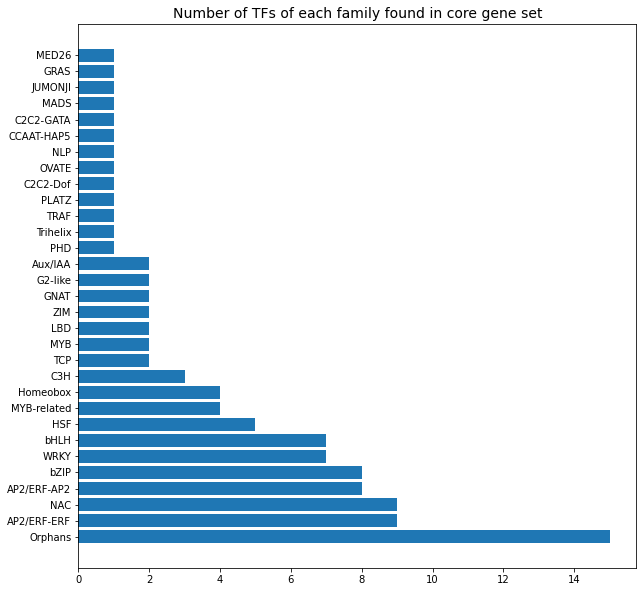

In [78]:
# now we can make a graph
## first, because it's just easier, make an overall graph of Count
plt.figure(figsize=(10,10))
plt.barh(familycounts.index,familycounts["Count"])
plt.title("Number of TFs of each family found in core gene set",fontsize=14)
plt.savefig("../../figures/barplot_TF_families_core_overall.pdf",bbox_inches="tight")

In [15]:
import seaborn as sns

In [80]:
tf.head()

,number for sorting purposes,protein name,family,gene ID,synonym,clone,all gene IDs,Unnamed: 7
0,1,ZmABI1,ABI3-VP1,Zm00001eb143690,VP1,pUT3351,Zm00001eb143690 Zm00001d042396 GRMZM2G133398,NaN
1,2,ZmABI2,ABI3-VP1,Zm00001eb427970,ABI2,pUT3663,Zm00001d026005 Zm00001eb427970 GRMZM2G018485,NaN
2,3,ZmABI3,ABI3-VP1,Zm00001eb066270,ABI3,pUT3236,Zm00001eb066270 Zm00001d001838 GRMZM2G149940,NaN
3,4,ZmABI4,ABI3-VP1,Zm00001eb051330,ABI4,pUT4675,Zm00001d033313 GRMZM2G098063 Zm00001eb051330,NaN
4,5,ZmABI5,ABI3-VP1,Zm00001eb218990,ABI5,pUT4673,Zm00001d013722 Zm00001eb218990 GRMZM2G320754,NaN


In [16]:
tfsub = tf[["gene ID","family"]]
tfsub = tfsub.drop_duplicates()

In [17]:
# make a figure showing the number of TFs of each family in the core set vs. number of TFs annotated in that family
## overlapping bar plots

# add the counts of overall annotated TFs
familycounts["Annotated_Count"] = pd.DataFrame(tfsub["family"].value_counts())["family"]
familycounts.head()

,Count,Upregulated_Count,Downregulated_Count,Annotated_Count
Orphans,15,14,9.0,300
AP2/ERF-ERF,9,8,3.0,143
NAC,9,9,3.0,172
AP2/ERF-AP2,8,7,7.0,91
bZIP,8,8,5.0,136


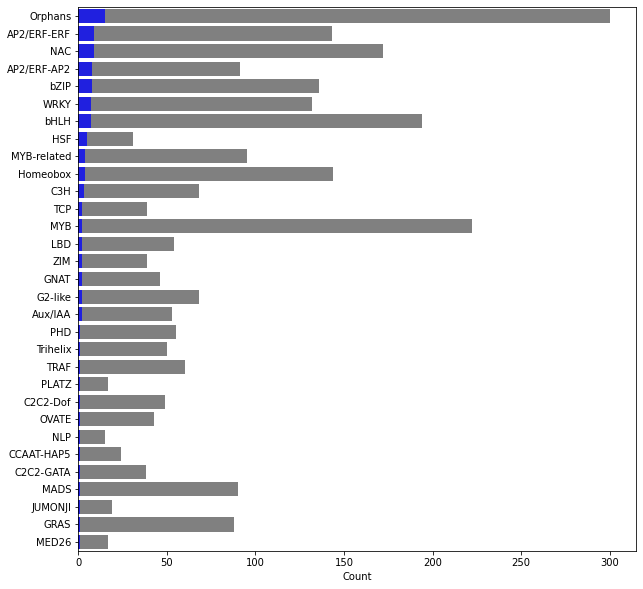

In [93]:
# make overlapping bar plots
ax = plt.subplots(figsize=(10,10))
ax = sns.barplot(y=familycounts.index, x=familycounts["Annotated_Count"],color="grey")
ax = sns.barplot(y=familycounts.index, x=familycounts["Count"],color="b")

In [95]:
familycounts.head()

,Count,Upregulated_Count,Downregulated_Count,Annotated_Count
Orphans,15,14,9.0,300
AP2/ERF-ERF,9,8,3.0,143
NAC,9,9,3.0,172
AP2/ERF-AP2,8,7,7.0,91
bZIP,8,8,5.0,136


In [94]:
familycounts.iloc[0,1]

14

In [18]:
# not super informative...let's do it by percent instead
## calculate percentages
pct = []
for i in range(len(familycounts.index)):
    num = familycounts.iloc[i,0]
    dem = familycounts.iloc[i,3]
    p = num/dem
    pct.append(p*100)
familycounts["Percent_in_Core"] = pct
familycounts.head()

,Count,Upregulated_Count,Downregulated_Count,Annotated_Count,Percent_in_Core
Orphans,15,14,9.0,300,5.000000
AP2/ERF-ERF,9,8,3.0,143,6.293706
NAC,9,9,3.0,172,5.232558
AP2/ERF-AP2,8,7,7.0,91,8.791209
bZIP,8,8,5.0,136,5.882353


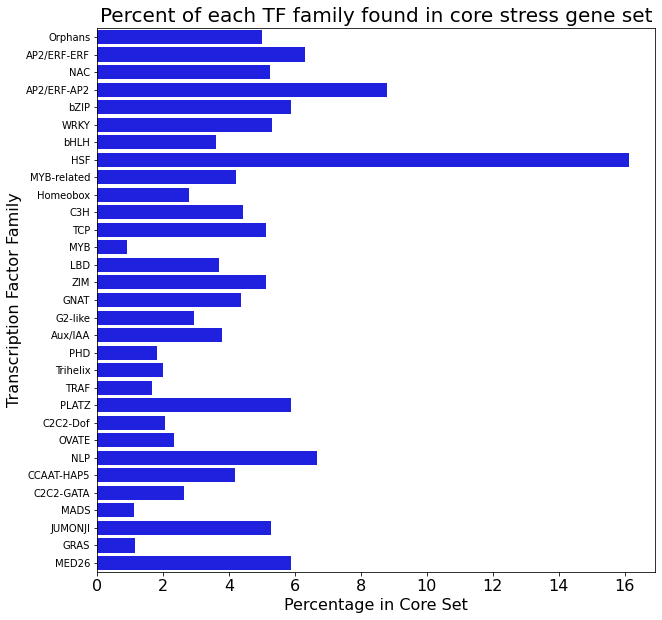

In [22]:
# make percentage barplot
ax = plt.subplots(figsize=(10,10))
ax = sns.barplot(y=familycounts.index,x=familycounts["Percent_in_Core"],color="b")
plt.title("Percent of each TF family found in core stress gene set",fontsize=20)
plt.ylabel("Transcription Factor Family",fontsize=16)
plt.xlabel("Percentage in Core Set",fontsize=16)
plt.xticks(fontsize=16)
plt.savefig("../../figures/TF_families_percent_core_barplot.svg",bbox_inches="tight")